# Those Ignorant, One-Armed Bandits

I've been thinking a lot about the [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem lately.  Here's the description from Wikipedia:

> In probability theory, the multi-armed bandit problem is a problem in which a gambler at a row of slot machines (sometimes known as "one-armed bandits") has to decide which machines to play, how many times to play each machine and in which order to play them. When played, each machine provides a random reward from a probability distribution specific to that machine. The objective of the gambler is to maximize the sum of rewards earned through a sequence of lever pulls.
 
I'm especially interested in this problem because I think it's a good exercise for thinking about how society should allocate scarce resources.  For example, when trying to combat an infectious disease we should spend a substantial amount on the immmediate response.  But we also need to invest in research on long-term solutions like vaccines and diagnostic tools even if these outcomes are more uncertain.  How do we decide how much to allocate to each of these areas over time?  This explore-exploit tradeoff is what makes these types of problems difficult to solve. 

The traditional problem above has some good solutions but I recently thought of a twist that hasn't been researched yet: What if you only know the collective score of a group of machines each round rather than the score of each individual machine (each individual is "ignorant" of it's own score)?  This seems to be precisely the problem we have in many policy situations: we change some policy but we're not sure if the effect we observe is due to our change, some other change (possibly from a different time step), or random noise.  Running a [randomized trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial) (RCT) can help cancel out the random noise and other effects, but even RCTs have issues with applicability, external validity, and scale.

Below I lay out the problem in Python and propose a few initial solutions, one of which converges.  For now, I limit the effect of each machine to a single time step and only change one at a time.  This isn't as complicated as reality but it allows me to reach an initial solution.

In [1]:
%matplotlib inline

import random
from collections import namedtuple
import statistics

import matplotlib.pyplot as plt
import matplotlib

## Initial Approach

My initial approach to solving this problem is to just select five random machines, get a score, then replace one of them at random.  If the resulting score is an improvement, I keep the new selection of machines for the next step.  This approach works fairly well, but it never converges because I am always randomly replacing a machine, reducing the score. 

In [2]:
def run_simple_simulation(num_levers, num_selected, steps):
    score = 0
    mus = list(range(1,num_levers+1))
    sigmas = list(1 for i in range(num_levers))
    Lever = namedtuple('Lever', ['mu', 'sigma'])
    levers = [Lever(mu=x[0], sigma=x[1]) for x in zip(mus, sigmas)]

    #Initialize
    sample = random.sample(levers, num_selected)
    score = sum([random.gauss(lever.mu, lever.sigma) for lever in sample])
    history = [score]
    optimal_score = levers[-1].mu*num_selected
    regret = [optimal_score-score]

    for i in range(2,steps+1):
        new_sample = list(sample) 
        new_sample[random.choice(range(num_selected))] = random.choice(levers)    
        new_score = sum([random.gauss(l.mu, l.sigma) for l in new_sample])

        if new_score > score:
            score = new_score
            sample = new_sample
            
        history.append(new_score)
        regret.append(optimal_score*i-sum(history))
        
    return {"sample": sample, "history": history, 
            "regret": regret, "levers": levers}

def display_results(result):    
    #https://stackoverflow.com/questions/1358977
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,7))
    ax1 = axes[0]
    ax1.plot(range(len(result["history"])), result["history"]) 
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Score')

    ax2 = axes[1]
    ax2.plot(range(len(result["regret"])), result["regret"]) 
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Regret')
    plt.show()

Selected Levers:
Mu: 99
Mu: 100
Mu: 100
Mu: 99
Mu: 99


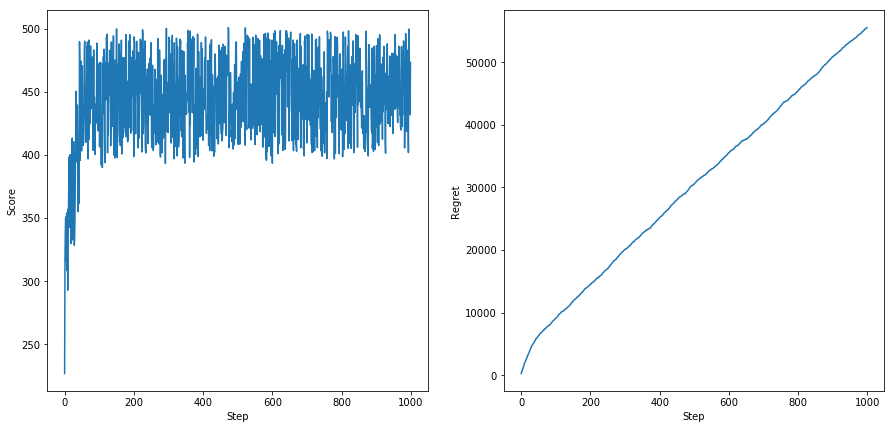

In [3]:
simple_result = run_simple_simulation(num_levers=100, num_selected=5, steps=1000)

print("Selected Levers:")
for lever in simple_result["sample"]:
    print("Mu: {0}".format(lever.mu))

display_results(simple_result)

## Improved Solution

To get around the non-convergence of the initial approach, I add a history of deltas to each machine.  Think of the history as the changes "caused" by each machine when it's added to an existing group.  So I start by selecting and pulling five levers, then replace the worst performing one with the best performing lever left out, then re-score the results with the new lever.  The score change is added to the new machine's deltas, and then the process above is repeated until it settles on the best machine.   

In reality, it's impossible to know if the new machine actually caused the change observed in the score.  This is because the new machine replaces an existing one and there's additional random noise from the probability distributions.  The equation for this process would look something like this:

`new_score = old_score - old_machine + new_machine + random_noise`

I only know the `new_score` and `old_score` in this equation -- the rest are unknowns.  But by assuming that the `new_machine_delta = new_score - old_score`, I am able to create a solution that converges on the best machine anyways.  This approach is kind of like an experiment without a control group.  I just assume the effect is entirely due to the machine I change.  By repeating it enough times, it leads to a fairly accurate result even without a control.

In [7]:
def run_history_simulation(num_levers, num_selected, steps):
    score = 0
    mus = list(range(1, num_levers+1))
    sigmas = list(1 for i in range(num_levers))
    Lever = namedtuple('Lever', ['mu', 'sigma', 'deltas'])
    levers = [Lever(mu=x[0], sigma=x[1], deltas=[]) for x in zip(mus, sigmas)]

    #Initialize
    sample = random.sample(levers, num_selected)
    score = sum([random.gauss(lever.mu, lever.sigma) for lever in sample])
    history = [score]
    optimal_score = levers[-1].mu*num_selected
    regret = [optimal_score-score]
    
    for i in range(2,steps+1):
        new_sample = list(sample) 
        old_lever = min(sample, key=lambda x : sum(x.deltas)/len(x.deltas) if x.deltas else 0)  
        new_lever = max(levers, key=lambda x : sum(x.deltas)/len(x.deltas) if x.deltas else 0)

        new_sample[new_sample.index(old_lever)] = new_lever    
        new_score = sum([random.gauss(l.mu, l.sigma) for l in new_sample])
        new_lever.deltas.append(new_score-score)
        if new_score > score:
            score = new_score
            sample = new_sample

        history.append(new_score)
        regret.append(optimal_score*i-sum(history))
        
    return {"sample": sample, "history": history, 
            "regret": regret, "levers": levers}

Selected Levers: 
Mu: 100, Mean Delta: -5.6185
Mu: 100, Mean Delta: -5.6185
Mu: 100, Mean Delta: -5.6185
Mu: 100, Mean Delta: -5.6185
Mu: 100, Mean Delta: -5.6185


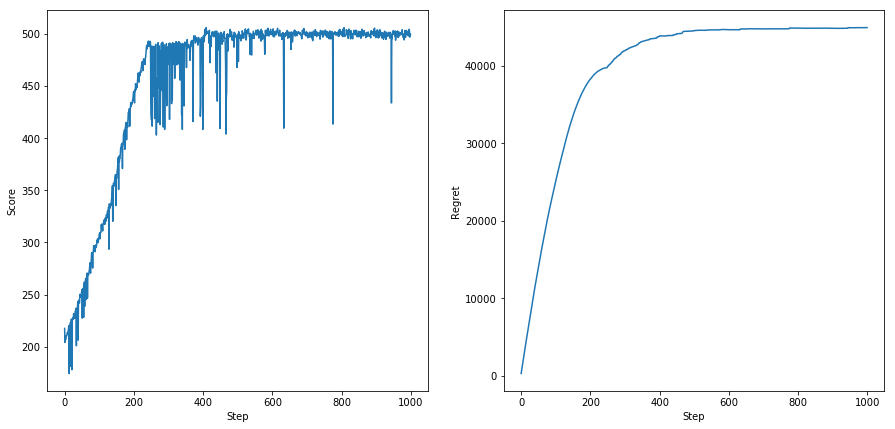

In [8]:
history_result = run_history_simulation(num_levers=100, num_selected=5, steps=1000)

print("Selected Levers: ")
for lever in history_result["sample"]:
    print("Mu: {0}, Mean Delta: {1:.4f}".format(lever.mu, 
                                        sum(lever.deltas)/len(lever.deltas)))

display_results(history_result)

Below are the final ten machines and their mean deltas.  Although they're not ordered perfectly, this approach still ends up selecting the machine with the highest mean value and lowest delta after enough steps:

In [9]:
for lever in history_result["levers"][-10:]:
    print("Mu: {0}, Mean Delta: {1:.4f}".format(lever.mu, 
                                        sum(lever.deltas)/len(lever.deltas)))

Mu: 91, Mean Delta: -6.0507
Mu: 92, Mean Delta: -6.7578
Mu: 93, Mean Delta: -6.0826
Mu: 94, Mean Delta: -5.6559
Mu: 95, Mean Delta: -7.0706
Mu: 96, Mean Delta: -5.7516
Mu: 97, Mean Delta: -8.1045
Mu: 98, Mean Delta: -5.6500
Mu: 99, Mean Delta: -5.6606
Mu: 100, Mean Delta: -5.6185


## Conclusion

In reality, the random noise in situations like these could be much, much larger, which might prevent an approach like this from converging.  In addition, society often makes many changes at once that can affect multiple future time steps, so it would be hard to associate score changes with a single machine.  But this solution is a start so maybe I can try to address these additional complications in the future. 